In [1]:
##import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Resizing


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

Data loading and pre-processing

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#original y_test
y_test_orig = y_test

#split into train and val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
y_train, y_val, y_test = to_categorical(y_train, 10), to_categorical(y_val, 10), to_categorical(y_test, 10)

# Define a function to preprocess images
def preprocess(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, [224, 224])/255.0
    return image, label

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

##validation data
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


**Model Building**

In [3]:
## Load MobileNetV2 with ImageNet weights, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

## Build the model with additional layers for CIFAR-10 classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

## Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Model Training**

In [4]:
# Train the model using the tf.data datasets
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Fine-tuning (optional)
#base_model.trainable = True
#model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.6753 - loss: 0.9809 - val_accuracy: 0.7852 - val_loss: 0.6073
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.7645 - loss: 0.6737 - val_accuracy: 0.8037 - val_loss: 0.5620
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - accuracy: 0.7815 - loss: 0.6302 - val_accuracy: 0.8085 - val_loss: 0.5362
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.7957 - loss: 0.5909 - val_accuracy: 0.8128 - val_loss: 0.5349
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - accuracy: 0.8055 - loss: 0.5668 - val_accuracy: 0.8127 - val_loss: 0.5303
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 37ms/step - accuracy: 0.8125 - loss: 0.5451 - val_accuracy: 0.8081 - val_loss: 0.5480
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.8189 - loss: 0.5197 - val_accuracy: 0.8216 - val_loss: 0.5115
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.8223 -

In [ ]:
#save model weights into disk
model.save('/content/drive/MyDrive/Segmentation Models/mobnet_model.h5')

In [ ]:
#save training history into disk
import pickle
with open('/content/drive/MyDrive/mobnet_trainhistDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
#loading training history from disk
history = pickle.load(open('/content/drive/MyDrive/mobnet_trainhistDict', 'rb'))

In [ ]:
#load model
import tensorflow
loaded_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/Segmentation Models/mobnet_model.h5')

**Model Evaluation**

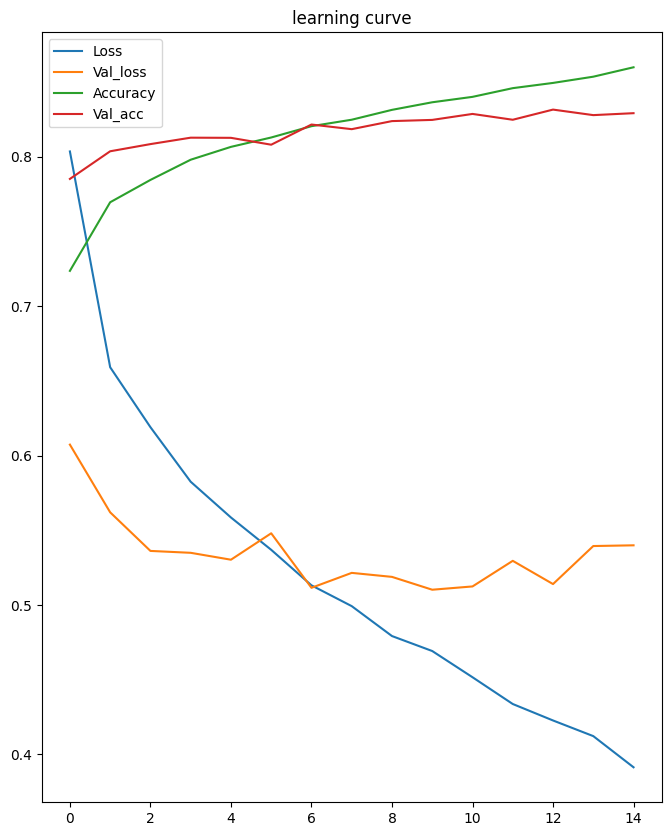

In [5]:
##set figsize
plt.figure(figsize = (8, 10))

##plot training curve
#plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_acc')
plt.title('learning curve')
plt.legend()

plt.show()

In [ ]:
##labels list
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog',
          'horse', 'ship', 'truck']

## Create tf.data.Dataset objects
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

evaluation = model.evaluate(test_dataset)
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")

##resize X_test
x_test_resized = tf.image.resize(x_test, [224, 224] )/255.0

##prediction on test data
y_pred = model.predict(x_test_resized)
y_pred = np.argmax(y_pred, axis=1)

##confusion matrix
cm = confusion_matrix(y_test_orig, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

##plot the cm
fig, ax = plt.subplots(figsize = (10, 10))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'summer')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8227 - loss: 0.5872
Test Accuracy: 82.32%
